<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Sergey Kolchenko (@KolchenkoSergey). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center>Assignment #6
### <center> Beating baselines in "How good is your Medium article?"
    
<img src='../../img/medium_claps.jpg' width=40% />


[Competition](https://www.kaggle.com/c/how-good-is-your-medium-article). The task is to beat "A6 baseline" (~1.45 Public LB score). Do not forget about our shared ["primitive" baseline](https://www.kaggle.com/kashnitsky/ridge-countvectorizer-baseline) - you'll find something valuable there.

**Your task:**
 1. "Freeride". Come up with good features to beat the baseline "A6 baseline" (for now, public LB is only considered)
 2. You need to name your [team](https://www.kaggle.com/c/how-good-is-your-medium-article/team) (out of 1 person) in full accordance with the [course rating](https://drive.google.com/open?id=19AGEhUQUol6_kNLKSzBsjcGUU3qWy3BNUg8x8IFkO3Q). You can think of it as a part of the assignment. 16 credits for beating the mentioned baseline and correct team naming.

In [2]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack,coo_matrix
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import TimeSeriesSplit

from bs4 import BeautifulSoup
from sklearn.linear_model import Lasso, LassoCV

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score

The following code will help to throw away all HTML tags from an article content.

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [3]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

Extract features `content`, `published`, `title` and `author`, write them to separate files for train and test sets.

In [5]:
def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):  
            
    content_list = []
    published_list =[]
    title_list =[]
    author_list =[]
    domain_list =[]
    tags_list = []
    

    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:
        
        for line in tqdm_notebook(inp_json_file):
            json_data = read_json_line(line)
            
            
            content = json_data['content'].replace('\n',' ').replace('\r',' ')
            content_list.append(strip_tags(content))
            
            published_list.append(json_data['published']['$date'])
            
            title_list.append(strip_tags(json_data['title']).split('\u2013')[0].strip().replace('\n',' ').replace('\r',' '))
            
            author_list.append(json_data['meta_tags']['author'].strip())
            
            domain_list.append(json_data['domain'])
            
            tags_str = []
            soup = BeautifulSoup(content, 'lxml')
            try:
                tag_block = soup.find('ul', class_='tags')
                tags = tag_block.find_all('a')
                for tag in tags:
                    tags_str.append(tag.text.translate({ord(' '):None, ord('-'):None}))
                tags = ' '.join(tags_str)
            except Exception:
                tags = 'None'
            
            tags_list.append(tags)
            
        df = pd.DataFrame()
        df['content'] = content_list
        df['published'] = pd.to_datetime(published_list, format='%Y-%m-%dT%H:%M:%S.%fZ')
        df['title'] = title_list
        df['author'] = author_list
        df['domain'] = domain_list
        df['tags'] = tags_list
        
        if is_train:
            df.sort_values(by ='published',inplace=True)

        features = ['content', 'published', 'title', 'author', 'domain', 'tags']
    
        prefix = 'train' if is_train else 'test'
        
        for feat in features:
            df[feat].to_csv(os.path.join(path_to_data,'{}_{}.txt'.format(prefix, feat)),sep=' ',index=None,header =None)



In [248]:
PATH_TO_DATA = './data/Medium/trainsortedtestnormal' 

In [8]:
# extract_features_and_write(PATH_TO_DATA, 'train.json', is_train=True)

In [9]:
# extract_features_and_write(PATH_TO_DATA, 'test.json', is_train=False)

In [241]:
%%time
tfidf_content = TfidfVectorizer(os.path.join(PATH_TO_DATA,'train_content.txt'),ngram_range=(1,2),max_features=100000)

with open(os.path.join(PATH_TO_DATA,'train_content.txt'),encoding="utf8") as train_content:
    X_train_content_sparse = tfidf_content.fit_transform(train_content)

with open(os.path.join(PATH_TO_DATA,'test_content.txt'),encoding="utf8") as test_content:
    X_test_content_sparse = tfidf_content.fit_transform(test_content)

Wall time: 11min 41s


In [11]:
X_train_content_sparse.shape,X_test_content_sparse.shape

((62313, 100000), (34645, 100000))

### saving for quick access

In [12]:
from scipy import sparse

sparse.save_npz("./data/medium/X_test_content_sparse_total_bigram2.npz", X_test_content_sparse)
# X_test_content_sparse = sparse.load_npz("./data/medium/X_test_content_sparse_total.npz")

sparse.save_npz("./data/medium/X_train_content_sparse_total_bigram2.npz", X_train_content_sparse)
# X_train_content_sparse = sparse.load_npz("./data/medium/X_train_content_sparse_total.npz")

** Titles **

In [5]:
tfidf_title = TfidfVectorizer(os.path.join(PATH_TO_DATA,'train_title.txt'),ngram_range=(1,2),max_features=100000)
#                               strip_accents='unicode', stop_words='english')

with open(os.path.join(PATH_TO_DATA,'train_title.txt'),encoding="utf8") as train_title:
    X_train_title_sparse = tfidf_title.fit_transform(train_title)
    
with open(os.path.join(PATH_TO_DATA,'test_title.txt'),encoding="utf8") as test_title:
    X_test_title_sparse = tfidf_title.fit_transform(test_title)

In [6]:
X_train_title_sparse.shape,X_test_title_sparse.shape

((62313, 100000), (34645, 100000))

** tags **

In [161]:
tfidf_tags = TfidfVectorizer(os.path.join(PATH_TO_DATA,'total_tags.txt'),ngram_range=(1,2),max_features=100000,stop_words='english')

with open(os.path.join(PATH_TO_DATA,'train_tags.txt'),encoding="utf8") as train_tags:
    X_train_tags_sparse = tfidf_tags.fit_transform(train_tags)
    
with open(os.path.join(PATH_TO_DATA,'test_tags.txt'),encoding="utf8") as test_tags:
    X_test_tags_sparse = tfidf_tags.fit_transform(test_tags)

In [162]:
X_train_tags_sparse.shape,X_test_tags_sparse.shape

((62313, 100000), (34645, 100000))

** Authors **

In [223]:
train_author_ = pd.read_csv(os.path.join(PATH_TO_DATA,'train_author.txt'),header=None,usecols=[0],names=["authors"])
test_author_ = pd.read_csv(os.path.join(PATH_TO_DATA,'test_author.txt'),header=None,usecols=[0],names=["authors"])

authors = pd.concat([train_author_,test_author_],axis=0,sort=False)

# train_author_list = set(train_author_.authors.value_counts().head(500).index)
train_author_list = set(train_author_.authors.value_counts().index)
test_author_list = set(test_author_.authors.value_counts().index)

common_author = train_author_list.intersection(test_author_list)

def encodecommonauthors(x):
    if x in common_author: return x
    else: return 'unknown'
    
authors = authors.authors.map(encodecommonauthors)

authors = pd.get_dummies(authors,drop_first=True)

X_train_author_sparse = authors.iloc[:train_author_.shape[0],:].values
X_test_author_sparse  = authors.iloc[train_author_.shape[0]:,:].values

X_train_author_sparse.shape, X_test_author_sparse.shape

((62313, 5841), (34645, 5841))

In [246]:
authors = pd.concat([train_author_,test_author_],axis=0,sort=False)
authors = pd.get_dummies(authors)

X_train_author_sparse = authors.iloc[:train_author_.shape[0],]
X_test_author_sparse = authors.iloc[train_author_.shape[0]:,]

X_train_author_sparse.shape, X_test_author_sparse.shape

((62313, 43885), (34645, 43885))

In [219]:
# train_author_ = pd.read_csv(os.path.join(PATH_TO_DATA,'train_author.txt'),header=None,usecols=[0],names=["authors"])
# test_author_ = pd.read_csv(os.path.join(PATH_TO_DATA,'test_author.txt'),header=None,usecols=[0],names=["authors"])

# authors = pd.concat([train_author_,test_author_],axis=0,sort=False)

# LE = LabelEncoder()
# LE.fit(authors.values.reshape(1,-1)[0])
# X_train_author_LE = LE.transform(train_author_.values.reshape(1,-1)[0])
# X_test_author_LE  = LE.transform(test_author_.values.reshape(1,-1)[0])

# OHE = OneHotEncoder(handle_unknown='ignore')
# OHE.fit(X_train_author_LE.reshape(-1,1))

# X_train_author_sparse = OHE.transform(X_train_author_LE.reshape(-1,1))
# X_test_author_sparse  = OHE.transform(X_test_author_LE.reshape(-1,1))

# X_train_author_sparse.shape, X_test_author_sparse.shape

((62313, 31331), (34645, 31331))

** domain **

In [96]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

train_domain_ = pd.read_csv(os.path.join(PATH_TO_DATA,'train_domain.txt'),header=None,usecols=[0],names=['domains'])
test_domain_ = pd.read_csv(os.path.join(PATH_TO_DATA,'test_domain.txt'),header=None,usecols=[0],names = ['domains'])

domains = pd.concat([train_domain_,test_domain_],axis=0,sort=False)

def toptwodomain(x):
    if x=='medium.com': return 0
    elif x=='hackernoon.com': return 1
    else: return 2
domains = domains.domains.map(toptwodomain)

domains = pd.get_dummies(domains,drop_first=True)

X_train_domain_sparse = domains.iloc[:train_domain_.shape[0],:].values
X_test_domain_sparse  = domains.iloc[train_domain_.shape[0]:,:].values

X_train_domain_sparse.shape, X_test_domain_sparse.shape

((62313, 2), (34645, 2))

** Date Columns **

In [197]:
X_time = pd.concat([X_train_time,X_test_time],axis=0)
X_author = pd.concat([train_author_,test_author_],axis=0)
X_time_author = pd.concat([X_time,X_author],axis=1).reset_index()
# X_time_author.head()

,index,date,authors
0,0,1970-01-01 00:00:00.001,Susan Bratton
1,1,1970-01-01 00:00:00.001,Ryo Ooishi
2,2,1970-01-18 03:21:32.400,なぞちゅう
3,3,1987-12-08 21:45:00.000,Internet Corporation LLC
4,4,2003-12-29 17:00:00.000,Mackenzie Oldridge


In [199]:
X_time_author_sorted = X_time_author.sort_values(by='date')
# X_time_author_sorted.tail()

,index,date,authors
95867,33554,2018-03-02 21:24:11.820,Niklas Goeke
95868,33555,2018-03-02 21:40:53.066,Christopher D. Connors
96921,34608,2018-03-02 23:56:22.397,Noah Madden
96535,34222,2018-03-03 01:16:52.284,The Academy
95949,33636,2018-03-03 04:00:24.116,Kris Gage


In [200]:
X_time_author_sorted['cum_count'] = X_time_author_sorted.groupby('authors').cumcount() + 1
# X_time_author_sorted.tail()

,index,date,authors,cum_count
95867,33554,2018-03-02 21:24:11.820,Niklas Goeke,40
95868,33555,2018-03-02 21:40:53.066,Christopher D. Connors,85
96921,34608,2018-03-02 23:56:22.397,Noah Madden,1
96535,34222,2018-03-03 01:16:52.284,The Academy,22
95949,33636,2018-03-03 04:00:24.116,Kris Gage,54


In [201]:
X_time_author['author_cum_count'] = X_time_author_sorted.loc[X_time_author.index,['cum_count']]

In [202]:
X_time_author.tail()

,index,date,authors,author_cum_count
96953,34640,2017-08-21 22:07:44.254,Lily Herman,8
96954,34641,2018-02-07 00:06:13.758,Ivan Gabriele,1
96955,34642,2017-12-28 18:00:38.412,Nick Troiano,3
96956,34643,2018-02-07 18:23:17.743,Sharrieff R. De'Johnette,2
96957,34644,2018-02-24 19:19:44.956,Alexander Vitanov,1


In [207]:
X_train_time_author = X_time_author.iloc[:X_train_time.shape[0],3]
X_test_time_author = X_time_author.iloc[X_train_time.shape[0]:,3]

In [9]:
X_train_time = pd.read_csv(os.path.join(PATH_TO_DATA,'train_published.txt'),header=None,names=['date'],
                                            parse_dates =['date'])
X_test_time = pd.read_csv(os.path.join(PATH_TO_DATA,'test_published.txt'),header=None,names=['date'],
                                         parse_dates =['date'])

In [10]:
X_train_time.shape,X_test_time.shape

((62313, 1), (34645, 1))

In [228]:
def add_time_features(df):
    new_df = pd.DataFrame(index=df.index)
    hour = df['date'].apply(lambda ts: ts.hour)
    new_df['morning'] = ((hour >= 7) & (hour <= 11)).astype('int')
    new_df["day"] = ((hour >= 12) & (hour <= 18)).astype('int')
    new_df["evening"] = ((hour >= 19) & (hour <= 23)).astype('int')
    new_df["night"] = ((hour >= 0) & (hour <= 6)).astype('int')
    new_df['is_weekend'] = df['date'].dt.weekday.isin([6,7]).astype('int')
#     new_df['year'] = df['date'].dt.year
#     new_df['month'] = df['date'].dt.month
#     new_df['weekday'] = df['date'].dt.weekday
#     new_df['hour'] = df['date'].dt.hour    
    return new_df

In [229]:
X_train_time_features_sparse = add_time_features(X_train_time)
X_test_time_features_sparse = add_time_features(X_test_time)
X_train_time_features_sparse.shape,X_test_time_features_sparse.shape

((62313, 5), (34645, 5))

** length features **

In [230]:
with open(os.path.join(PATH_TO_DATA,'train_content.txt'),encoding="utf8") as train_content:
    length =[] 
    for line in train_content:
        length.append(len(line))
X_train_time_features_sparse['length'] = length

with open(os.path.join(PATH_TO_DATA,'test_content.txt'),encoding="utf8") as test_content:
    length =[] 
    for line in test_content:
        length.append(len(line))
X_test_time_features_sparse['length'] = length

with open(os.path.join(PATH_TO_DATA,'train_tags.txt'),encoding="utf8") as train_tags:
    length =[] 
    for line in train_tags:
        length.append(len(line))
X_train_time_features_sparse['tag_length'] = length

with open(os.path.join(PATH_TO_DATA,'test_tags.txt'),encoding="utf8") as test_tags:
    length =[] 
    for line in test_tags:
        length.append(len(line))
X_test_time_features_sparse['tag_length'] = length

*** Author count ***

In [231]:
X_train_time_features_sparse['author_cum_count'] = X_train_time_author.values
X_test_time_features_sparse['author_cum_count'] = X_test_time_author.values

In [232]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
minmax.fit(X_train_time_features_sparse)
X_train_time_features_sparse[X_train_time_features_sparse.columns] = minmax.transform(X_train_time_features_sparse)
X_test_time_features_sparse[X_test_time_features_sparse.columns] = minmax.transform(X_test_time_features_sparse)

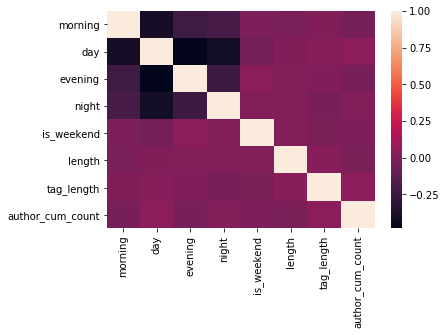

In [233]:
import seaborn as sns
sns.heatmap(X_test_time_features_sparse.corr());

In [234]:
X_train_time_features_sparse.head()

,morning,day,evening,night,is_weekend,length,tag_length,author_cum_count
0,0.0,0.0,0.0,1.0,0.0,0.012452,0.457944,0.0
1,0.0,0.0,0.0,1.0,0.0,0.012102,0.000000,0.0
2,0.0,0.0,0.0,1.0,1.0,0.005394,0.102804,0.0
3,0.0,0.0,1.0,0.0,0.0,0.026190,0.420561,0.0
4,0.0,1.0,0.0,0.0,0.0,0.029159,0.140187,0.0


**Read train target and split data for validation.**

In [32]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')
y_train = train_target['log_recommends'].values

In [33]:
y_train

array([9.01201, 3.49651, 0.69315, ..., 3.55535, 1.09861, 4.43082])

In [31]:
X_train_time_unsorted = pd.read_csv(os.path.join(PATH_TO_DATA,'train_published_unsorted.txt'),header=None,names=['date'],
                                            parse_dates =['date'])
# X_train_time_unsorted.head()

In [34]:
y_train_date = X_train_time_unsorted.copy()
y_train_date['log_recommends'] = y_train
y_train_date.sort_values(by = 'date',inplace=True)
y_train_date.head()

,date,log_recommends
24068,1970-01-01 00:00:00.001,1.09861
59081,1970-01-01 00:00:00.001,2.56495
54757,1970-01-18 03:21:32.400,0.69315
32182,1987-12-08 21:45:00.000,1.09861
33152,2003-12-29 17:00:00.000,3.52636


In [73]:
y_train = y_train_date['log_recommends'].values
y_train

array([1.09861, 2.56495, 0.69315, ..., 1.38629, 1.09861, 3.09104])

In [20]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA, 
                                                      'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [240]:
from scipy import sparse
X_train_content_sparse = sparse.load_npz("./data/medium/X_train_content_sparse_total_bigram.npz")
X_test_content_sparse = sparse.load_npz("./data/medium/X_test_content_sparse_total_bigram.npz")

In [247]:
X_train_sparse = hstack([
                          X_train_domain_sparse,
                          X_train_content_sparse,
#                           X_train_title_sparse,                          
                          X_train_tags_sparse,
                          X_train_author_sparse,
                          X_train_time_features_sparse]).tocsr()

X_test_sparse = hstack([
                         X_test_domain_sparse,
                         X_test_content_sparse,
#                          X_test_title_sparse,
                         X_test_tags_sparse,
                         X_test_author_sparse,
                         X_test_time_features_sparse]).tocsr()

train_part_size = int(0.7 * train_target.shape[0])
y_train_part = y_train[:train_part_size]
y_valid = y_train[train_part_size:]

X_train_part_sparse = X_train_sparse[:train_part_size, :]
X_valid_sparse =  X_train_sparse[train_part_size:, :]


In [238]:
lridge = Ridge(random_state=17)
lridge.fit(X_train_part_sparse,y_train_part)
mean_absolute_error(y_valid,lridge.predict(X_valid_sparse)) ## titles +authors+ content + len + domain + author count

1.1455953006628172

In [79]:
lridge = Ridge(random_state=17)
lridge.fit(X_train_part_sparse,y_train_part)
mean_absolute_error(y_valid,lridge.predict(X_valid_sparse)) ## titles +authors+ content

1.1885180788166347

In [90]:
lridge = Ridge(random_state=17)
lridge.fit(X_train_part_sparse,y_train_part)
mean_absolute_error(y_valid,lridge.predict(X_valid_sparse)) ## titles+author+contents + length + month + weekday

1.180886097235884

In [93]:
lridge = Ridge(random_state=17)
lridge.fit(X_train_part_sparse,y_train_part)
mean_absolute_error(y_valid,lridge.predict(X_valid_sparse)) 
## titles+author+contents + length + month + weekday -titles

1.1637991281859497

In [152]:
lridge = Ridge(random_state=17)
lridge.fit(X_train_part_sparse,y_train_part)
mean_absolute_error(y_valid,lridge.predict(X_valid_sparse)) 
## titles+author+contents + length -titles +domain

1.1537652168096677

In [99]:
lridge = Ridge(random_state=17)
lridge.fit(X_train_part_sparse,y_train_part)
mean_absolute_error(y_valid,lridge.predict(X_valid_sparse)) 
## titles+author+contents + length + month + weekday -titles + domain

1.1563604098678086

In [106]:
lridge = Ridge(random_state=17)
lridge.fit(X_train_part_sparse,y_train_part)
mean_absolute_error(y_valid,lridge.predict(X_valid_sparse)) 
## titles+author (500)+contents + length + month + weekday -titles + domain

1.1805347780243187

In [243]:
lridge = Ridge(random_state=17)
lridge.fit(X_train_part_sparse,y_train_part)
mean_absolute_error(y_valid,lridge.predict(X_valid_sparse)) 
## titles+author+contents + length  -titles + domain +tags

1.1362971720944763

In [160]:
lridge = Ridge(random_state=17)
lridge.fit(X_train_part_sparse,y_train_part)
mean_absolute_error(y_valid,lridge.predict(X_valid_sparse)) 
## titles+author+contents + length +alltime -titles + domain

1.1459182989130716

In [164]:
lridge = Ridge(random_state=17)
lridge.fit(X_train_part_sparse,y_train_part)
mean_absolute_error(y_valid,lridge.predict(X_valid_sparse)) 
## titles+author+contents + length +alltime -titles + domain +tags

1.1273207693588723

In [175]:
lridge = Ridge(random_state=17)
lridge.fit(X_train_part_sparse,y_train_part)
mean_absolute_error(y_valid,lridge.predict(X_valid_sparse)) 
## titles+author+contents + length +alltime(removed hour and year) -titles + domain +tags

1.1405338718468658

In [186]:
lridge = Ridge(random_state=17,alpha=15)
lridge.fit(X_train_part_sparse,y_train_part)
mean_absolute_error(y_valid,lridge.predict(X_valid_sparse)) 
## titles+author+contents + length +alltime(removed hour and year) -titles + domain +tags

1.2198752038861405

In [225]:
lridge = Ridge(random_state=17,alpha=15)
lridge.fit(X_train_part_sparse,y_train_part)
mean_absolute_error(y_valid,lridge.predict(X_valid_sparse)) 
## titles+author+contents + length +alltime(removed hour and year) -titles + domain +tags +author count

1.2149888814331062

In [222]:
lridge = Ridge(random_state=17,alpha=20)
lridge.fit(X_train_part_sparse,y_train_part)
mean_absolute_error(y_valid,lridge.predict(X_valid_sparse)) 
## titles+all author+contents + length +alltime(removed hour and year) -titles + domain +tags +author count

1.2404655709504302

In [249]:
lridge = Ridge(random_state=17,alpha=15)
lridge.fit(X_train_part_sparse,y_train_part)
mean_absolute_error(y_valid,lridge.predict(X_valid_sparse)) 
## titles+author+contents + length +alltime(removed hour and year) -titles + domain +tags +author count

1.216270805814987

### Submission file

In [165]:
y_train

array([1.09861, 2.56495, 0.69315, ..., 1.38629, 1.09861, 3.09104])

In [101]:
lridge.fit(X_train_sparse,y_train)
prediction = lridge.predict(X_test_sparse)

pred_adjusted = prediction+ (4.33328 -prediction.mean())
pred_adjusted.mean(),prediction.mean()

(4.333279999999999, 2.897967500402306)

In [166]:
lridge.fit(X_train_sparse,y_train)
prediction = lridge.predict(X_test_sparse)

pred_adjusted = prediction+ (4.33328 -prediction.mean())
pred_adjusted.mean(),prediction.mean()

(4.33328, 2.4465076845087337)

In [250]:
lridge.fit(X_train_sparse,y_train)
prediction = lridge.predict(X_test_sparse)

pred_adjusted = prediction+ (4.33328 -prediction.mean())
pred_adjusted.mean(),prediction.mean()

(4.333280000000001, 2.32828612005456)

In [102]:
write_submission_file(pred_adjusted, './assignment6_submissions/assignment6_medium_submission_adjusted_13.csv')
#CV 1.1563604098678086 #LB 1.66276

In [167]:
write_submission_file(pred_adjusted, './assignment6_submissions/assignment6_medium_submission_adjusted_14.csv')
#CV 1.1273207693588723 #LB 1.67924

In [227]:
write_submission_file(pred_adjusted, './assignment6_submissions/medium_submission_1.csv')
#CV 1.2404655709504302 #LB 1.68386

In [245]:
write_submission_file(pred_adjusted, './assignment6_submissions/medium_submission_2.csv')
#CV 1.1362971720944763 #LB 1.668262

In [251]:
write_submission_file(pred_adjusted, './assignment6_submissions/medium_submission_5.csv')
#CV 1.1362971720944763 #LB 1.668262

That's it for the assignment. Much more credits will be given to the winners in this competition, check [course roadmap](https://mlcourse.ai/roadmap). Do not spoil the assignment and the competition - don't share high-performing kernels (with MAE < 1.5).

Some ideas for improvement:

- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used C=1 as a regularization parameter, this can be changed
- SGD and Vowpal Wabbit will learn much faster
- Play around with blending and/or stacking. An intro is given in [this Kernel](https://www.kaggle.com/kashnitsky/ridge-and-lightgbm-simple-blending) by @yorko 
- In our course, we don't cover neural nets. But it's not obliged to use GRUs/LSTMs/whatever in this competition.

Good luck!

<img src='../../img/kaggle_shakeup.png' width=50%>